In this notebook, we finally build a recommender.

In [27]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

# Preps

First, let's get our dataset and construct a plan:

In [28]:
data = pd.read_csv(r'E:\parsing project\merged_after_nlp.csv')

Assign ids for encoding and decoding:

In [29]:
author_ids_dict = dict()
author_ids_dict_rev = dict()
author_ids = 0
authors = set(data['authors'])

for i in authors:
    author_ids_dict[author_ids] = i
    author_ids_dict_rev[i] = author_ids
    author_ids += 1

item_ids_dict = dict()
item_ids_dict_rev = dict()
item_ids = 0
items = set(data['product'])

for i in items:
    item_ids_dict[item_ids] = i
    item_ids_dict_rev[i] = item_ids
    item_ids += 1
    
data['author_id'] = data['authors'].map(author_ids_dict_rev)
data['item_id'] = data['product'].map(item_ids_dict_rev)

In [30]:
with open('author_ids_dict', 'wb') as q:
  pickle.dump(author_ids_dict, q)
  q.close()
with open('author_ids_dict_rev', 'wb') as q:
  pickle.dump(author_ids_dict_rev, q)
  q.close()
with open('item_ids_dict', 'wb') as q:
  pickle.dump(item_ids_dict, q)
  q.close()
with open('item_ids_dict_rev', 'wb') as q:
  pickle.dump(item_ids_dict_rev, q)
  q.close()

In [31]:
data.head(1)

,author_date,review_text,product,rating out of 5,date,authors,Price,nm,Design House,Fragrance Notes,Year,author_id,item_id,oz,Price per oz ($),for_nlp,num_rating
0,"20300_written by jan on december 06, 2022",one of my favorites!!! i don't care when i wea...,kate spade live colorfully,5 stars,2022-12-06,jan,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,10006,221,0.27,74.04,0,5.0


In [32]:
data['num_rating'] = data['num_rating'].astype(int)

In [33]:
data[data[['author_id', 'item_id', 'num_rating']].duplicated()].head(1) 

,author_date,review_text,product,rating out of 5,date,authors,Price,nm,Design House,Fragrance Notes,Year,author_id,item_id,oz,Price per oz ($),for_nlp,num_rating
22,"20324_written by vrod on january 01, 2016",i just love the smell of this perfume and i ge...,kate spade live colorfully,5 stars,2016-01-01,vrod,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,17466,221,0.27,74.04,0,5


It seems that we have duplicated reviews - drop them if the ratings are identical.

In [34]:
data_for_rec = data[['author_id', 'item_id', 'num_rating']].drop_duplicates().reset_index(drop = True)

In [35]:
data_for_rec = data_for_rec.reset_index(drop=True)

137 observations rated an item twice or more with different ratings - I decided to keep the lowest rating:

In [36]:
data_for_rec = data_for_rec.sort_values(['author_id', 'num_rating']).drop_duplicates(subset = ['author_id', 'item_id'], keep= 'first')

In [37]:
def ismissing(df):
    for i in df.columns:
        print(f'Missing data for column {i}: {round((100*df[i].isna().sum()/len(df)), 3)}%')

In [38]:
ismissing(data_for_rec) #no missing values

Missing data for column author_id: 0.0%
Missing data for column item_id: 0.0%
Missing data for column num_rating: 0.0%


Text(0.5, 1.0, 'Reviews per user')

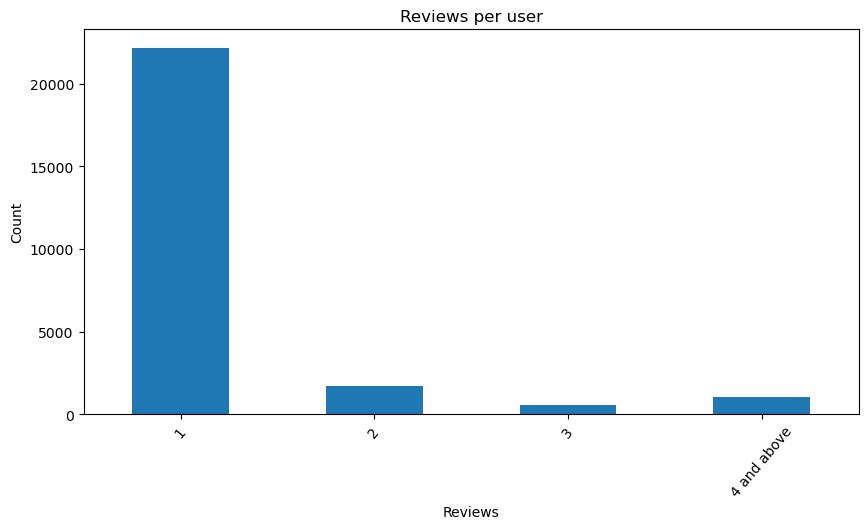

In [39]:
plt.figure(figsize = (10,5))
r_count = data_for_rec.groupby('author_id')['num_rating'].agg('count').value_counts()
r_count.groupby(np.where(r_count.index > 3, '4 and above', r_count.index)).sum().plot(kind = 'bar')
plt.xticks(rotation=50)
plt.xlabel('Reviews')
plt.ylabel('Count')
plt.title('Reviews per user')

It seems like most of the users only left one review. The extreme skewedness of reviews per user can be a potential indicator of lack of motivation/reward to leave more reviews. The business (site owners) might consider adding some incentives to encourage people to leave more reviews/rating stars. What I noticed on the UI of this particular site is that it is not possible to leave a star review without leaving a text review, but it is possible to leave a text review without leaving a star review. This UI element would probably discourage some users to leave star ratings, since not all users want to write text reviews to give a star rating (I would argue that most of the users would be happy to just give it a star rating, since that is less troublesome).


This makes it harder to build a robust recommendation system; however, we can try to go hybrid - recommend the most popular items for users with less than 3 reviews and use item-item CF for users with 3 or more reviews. Let's also look at the rating-item distribution once again:

([], [])

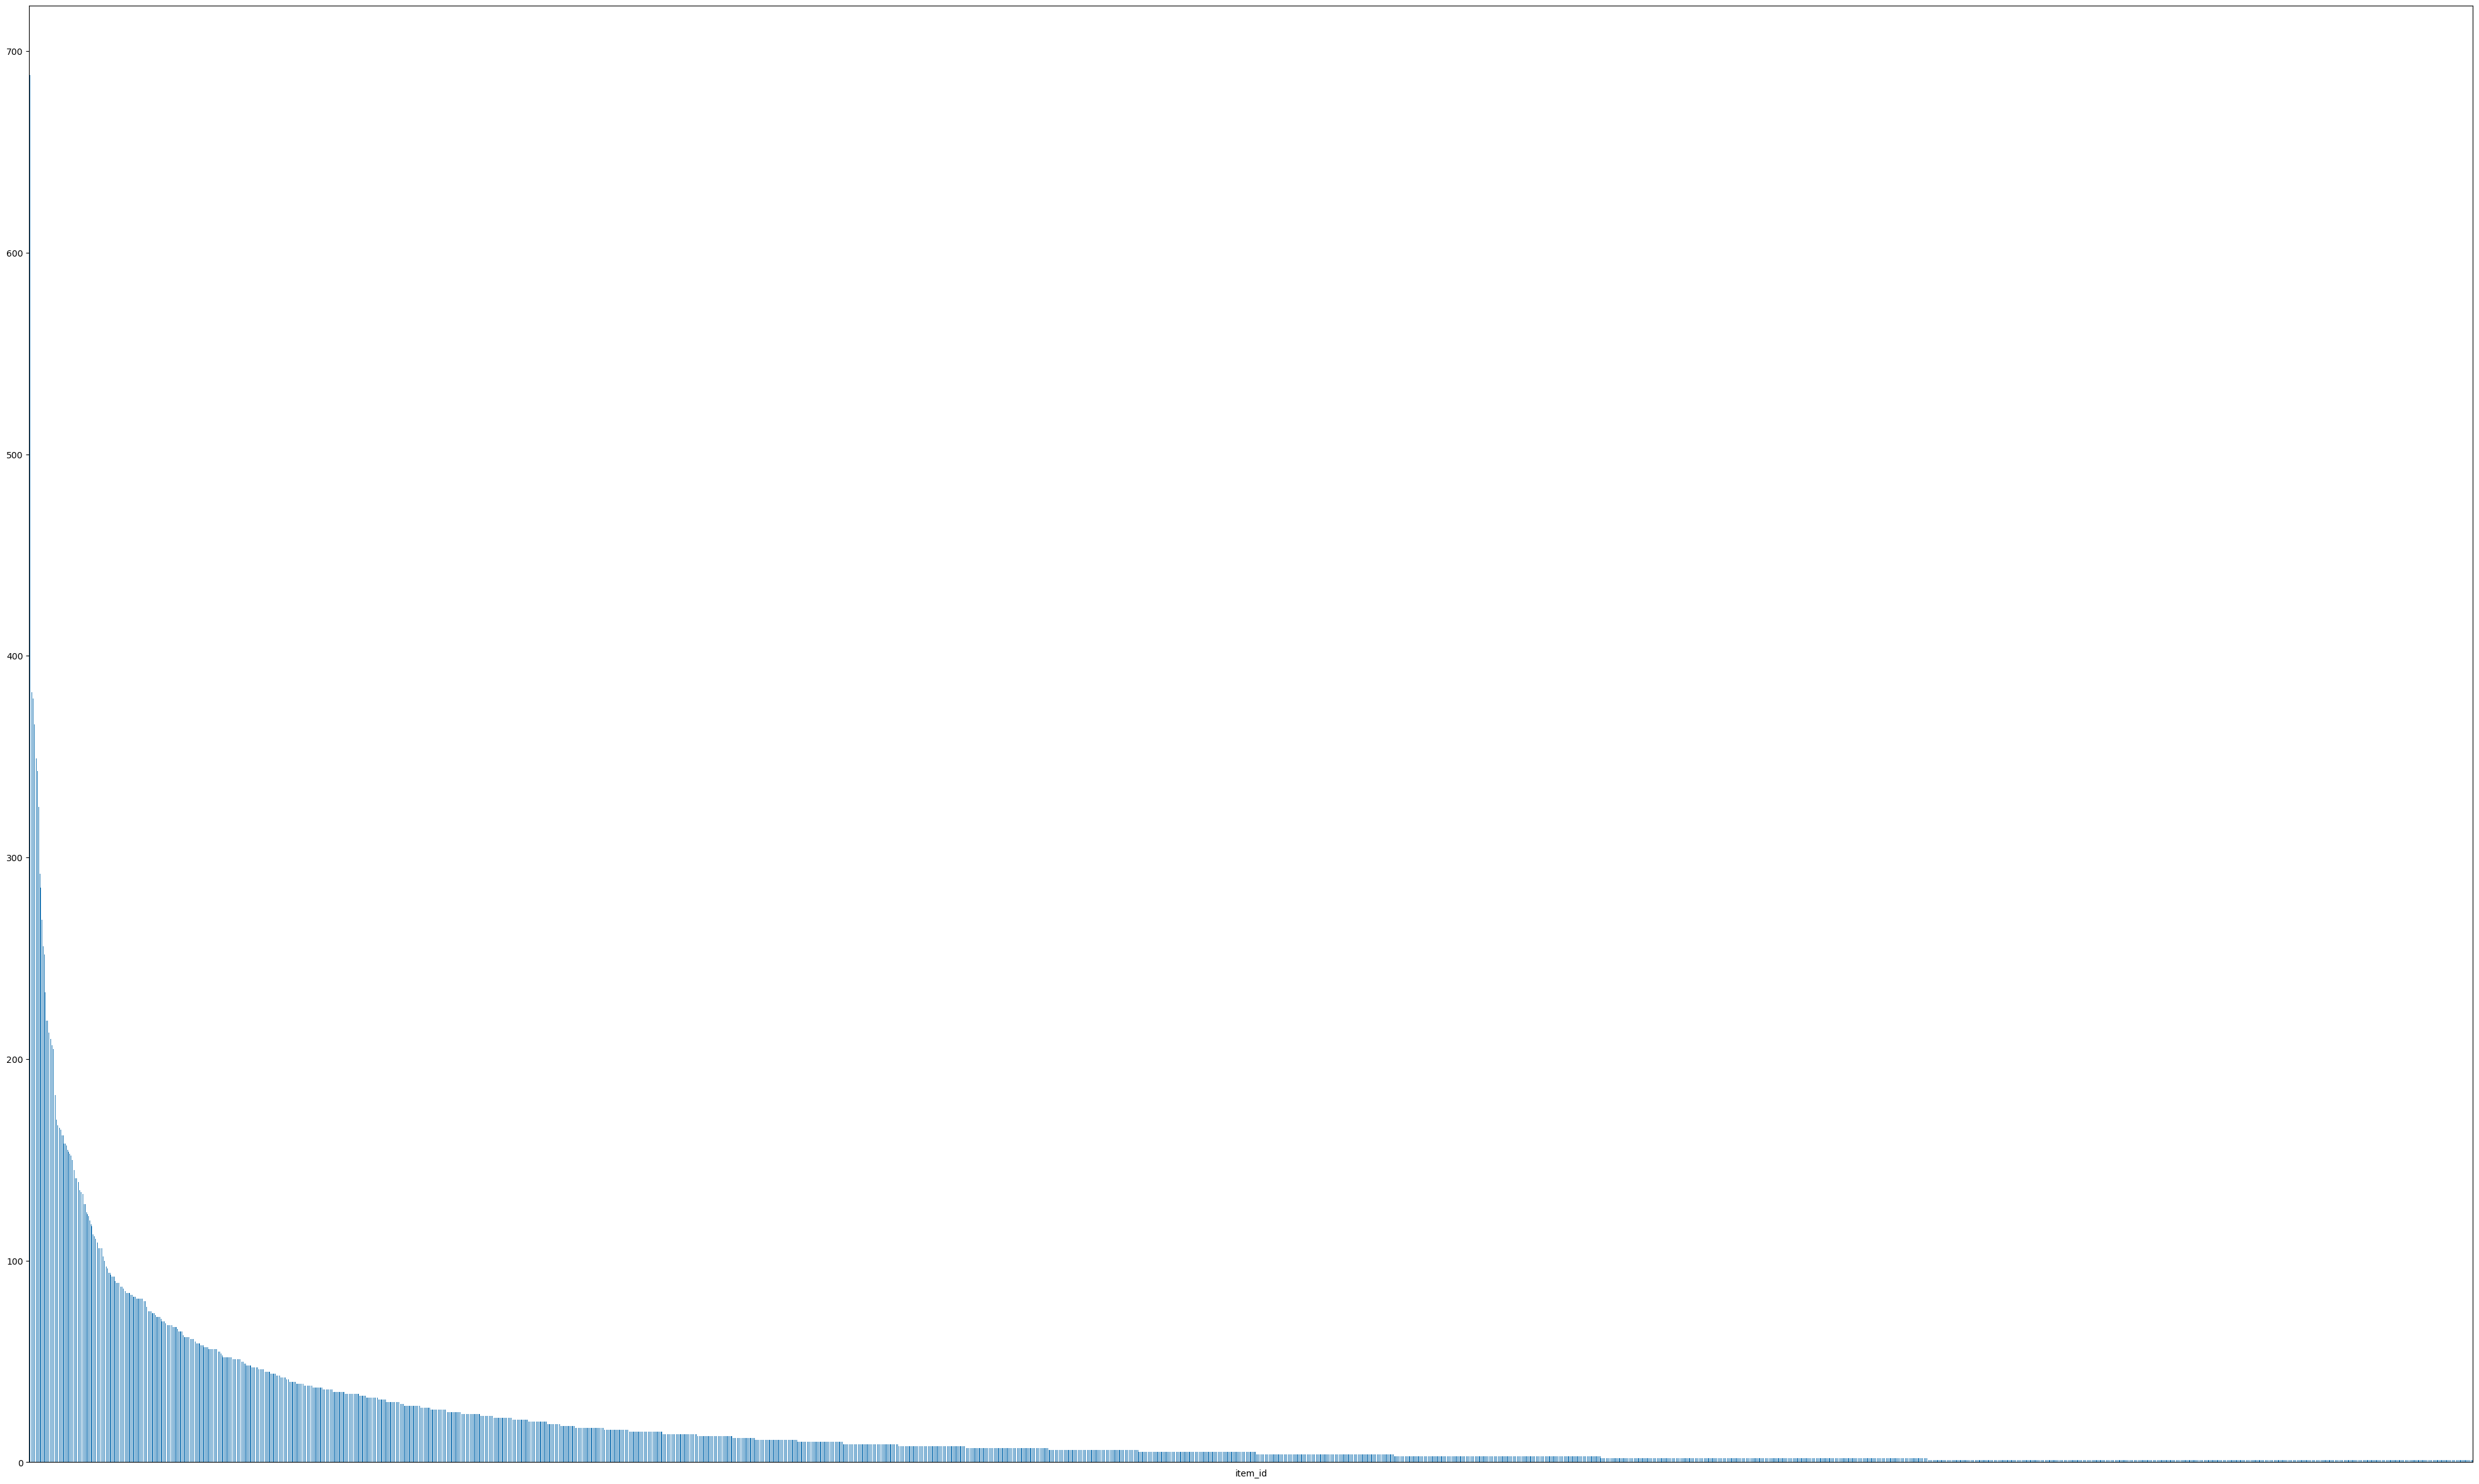

In [40]:
plt.figure(figsize = (50, 30))
data_for_rec.groupby('item_id')['num_rating'].count().sort_values(ascending=False).plot(kind = 'bar')
plt.xticks([])

In [41]:
#sum of the items with less than 5 ratings
(data_for_rec.groupby('item_id')['num_rating'].count().sort_values(ascending=False) < 5).sum()

1095

The rating item distribution is heavily skewed as well. Out of 2200 items, half of the items have less than 5 ratings.

Baseline recommender: Recommend the most rated items (top 50):

In [42]:
mostrated50 = data_for_rec.groupby('item_id')['num_rating'].agg(['count', 'mean']).sort_values(by = ['count', 'mean'], ascending= False)['count'][:50]

Choose items with at least 20 reviews:

In [43]:
filteritem = data_for_rec.groupby('item_id')['author_id'].count()
itemids = filteritem[filteritem >=20].index
atleast20items = data_for_rec[data_for_rec['item_id'].isin(itemids)]

Let's see how sparse our user-item matrix is:

In [44]:
sparsity = atleast20items[['author_id', 'item_id']].nunique()
round(100 * len(atleast20items)/(sparsity[0] * sparsity[1]), 3)

0.309

This basically tells us that only 0.3% of our matrix has values, which implies that our matrix is extremely sparse (i.e. most entries are zero).

In [45]:
from surprise import Dataset, SVD,  Reader, BaselineOnly, accuracy
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise.model_selection import KFold

In [46]:
reader = Reader(line_format="user item rating", rating_scale=(1,5))
data = Dataset.load_from_df(atleast20items, reader = reader)

Custom test set - from each user, sample one observation for the test set:

In [47]:
test = atleast20items.groupby('item_id').apply(lambda x: x.sample(5, random_state=42)).reset_index(drop=True)
len(set(test['author_id']))

train = pd.concat([atleast20items, test]).drop_duplicates(keep= False).reset_index(drop=True)

In [48]:
assert len(train)  + len(test) == len(atleast20items)

In [49]:
print(f"Unique authors in train: {train['author_id'].nunique()}")
print(f"Unique authors in test: {test['author_id'].nunique()}")
print(f"Unique items in train: {train['item_id'].nunique()}")
print(f"Unique items in test: {test['item_id'].nunique()}")

Unique authors in train: 19410
Unique authors in test: 2063
Unique items in train: 466
Unique items in test: 466


If we use cutoff of 20, we are only left with 466 items. However, based on tests, our recommendations are better on average. In 'real-world' we would have to select this cutoff more carefully. Besides item-item cf, I have also tried other methods such as ALS - however, it did not perform well, heavily relies on both users and items.

In [50]:
traindf = Dataset.load_from_df(train, reader = reader)
testdf = Dataset.load_from_df(test, reader = reader)

trainset = traindf.build_full_trainset()
#testset = testdf.build_full_trainset()

In [51]:
#bsl_options = {"method": "als", "n_epochs": 10, "reg_u": 10, "reg_i": 5}
#algo = BaselineOnly(bsl_options=bsl_options)
sim_options = {
    "name": "cosine",
    "user_based": False,  
}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


The method above uses cosine similarity between items to calculate the similarity score. We then sort users by similarity score and leave top k similar items, where k is the number of recommended items.

Calculate rmse for train and test predictions:

In [52]:
testlist = []

for i in range(len(test)):
    ts = (test['author_id'][i], test['item_id'][i], test['num_rating'][i])
    testlist.append(ts)

trainlist = []

for i in range(len(train)):
    tr = (train['author_id'][i], train['item_id'][i], train['num_rating'][i])
    trainlist.append(tr)

In [53]:
preds_train = []
preds_test = []

for j in trainlist:
    preds_train.append(algo.predict(j[0], j[1], j[2])[3])

for d in testlist:
    preds_test.append(algo.predict(d[0], d[1], d[2])[3])



In [54]:
actuals_train, actuals_test = train['num_rating'].values, test['num_rating'].values

all5_tr, all5_tst = [5] * len(actuals_train), [5] * len(actuals_test)

def rmse(ytrue, ypred):
    
    error = (ytrue - ypred)**2

    return round(np.sqrt(np.mean(error)), 5)

print(f"Train rmse: {rmse(actuals_train, preds_train)}")
print(f"Test rmse: {rmse(actuals_test, preds_test)}")
print(f"Predict everything as 5 train rmse: {rmse(actuals_train, all5_tr)}")
print(f"Predict everything as 5 test rmse: {rmse(actuals_test, all5_tst)}")

Train rmse: 0.45352
Test rmse: 1.00359
Predict everything as 5 train rmse: 0.93118
Predict everything as 5 test rmse: 1.02856


The model overfits. Let's compute cross-validated score:

In [55]:
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9316  0.9295  0.9312  0.9034  0.9244  0.9240  0.0106  
MAE (testset)     0.5229  0.5211  0.5272  0.5116  0.5213  0.5208  0.0051  
Fit time          0.04    0.04    0.05    0.04    0.05    0.04    0.00    
Test time         0.06    0.06    0.06    0.27    0.05    0.10    0.09    


{'test_rmse': array([0.93162974, 0.92952276, 0.93121127, 0.90335751, 0.92443401]),
 'test_mae': array([0.5228883 , 0.52109154, 0.52720886, 0.51159975, 0.52125755]),
 'fit_time': (0.0400540828704834,
  0.04398751258850098,
  0.04700922966003418,
  0.04400897026062012,
  0.048998117446899414),
 'test_time': (0.05501866340637207,
  0.057021379470825195,
  0.056014060974121094,
  0.2720677852630615,
  0.05426192283630371)}

The average cross-validation score shows RMSE of around 0.92 which is not very good but, at the same time, not very terrible. Since it is hard to quantify user preferences, it is not a good idea to rely solely on the cost functions. We would have to test the system in the real world.

In [32]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset) #prediction matrix of all users for all items

In [76]:
def get_top_n(predictions, n, items_onlyf = False):


    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    if items_onlyf == True:

        items_only = defaultdict(list)
        for i in top_n.keys():
            lst = [item for item, val in top_n[i]]
            items_only[i] = lst


    return items_only if items_onlyf == True else top_n

In [78]:
recommended = get_top_n(predictions, n=10, items_onlyf= True)

# Fit on full data

After finishing our evaluation, we must fit the algo on our full (train + test) dataset.

In [41]:
#fit full data
full_train = data.build_full_trainset()
algo.fit(trainset)

Estimating biases using als...


In [42]:
full_test = full_train.build_anti_testset()
full_predictions = algo.test(full_test)

In [45]:
top_n = get_top_n(predictions, 20, items_onlyf = True)

In [68]:
#top items that user has not rated
def decode(top_n, decodefrom):
    decoded = defaultdict(list)
    for user in top_n.keys():
        for i in top_n[user]:
            decoded[user].append(decodefrom[i]) 
    return decoded

In [70]:
decodedrecs = decode(top_n, item_ids_dict)

In [129]:
atleast20items.to_csv('atleast20items.csv', index = False)

We now need to work on the UI. What is the most sensible and cheap way to make an accessible UI? Telegram is a quite popular messenger now and it has an important feature - bots. We can throw in our recommender system inside of a bot, so user inputs some data and gets some predictions. This is done in the next notebook. The bot demo video is already inside the repository, check it out. 